In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os


In [7]:
df = pd.read_csv(r"C:\Users\RITIKA\Downloads\archive\customer_shopping_data.csv")
df.head(5)

invoice_no customer_id  gender  age  category  quantity    price  \
0    I138884     C241288  Female   28  Clothing         5  1500.40   
1    I317333     C111565    Male   21     Shoes         3  1800.51   
2    I127801     C266599    Male   20  Clothing         1   300.08   
3    I173702     C988172  Female   66     Shoes         5  3000.85   
4    I337046     C189076  Female   53     Books         4    60.60   

  payment_method invoice_date   shopping_mall  
0    Credit Card     5/8/2022          Kanyon  
1     Debit Card   12/12/2021  Forum Istanbul  
2           Cash    9/11/2021       Metrocity  
3    Credit Card   16/05/2021    Metropol AVM  
4           Cash   24/10/2021          Kanyon

In [9]:
print(df.info())
print(df.isnull().sum())

df = df.dropna(subset=['customer_id'])

df = df[~df['invoice_no'].astype(str).str.startswith('C')]

df['total_price'] = df['price'] * df['quantity']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB
None
invoice_no        0
customer_id       0
gender            0
age               0
category          0
quantity          0
price             0
payment_method    0
invoice_date      0
shopping_mall     0
dtype: int64


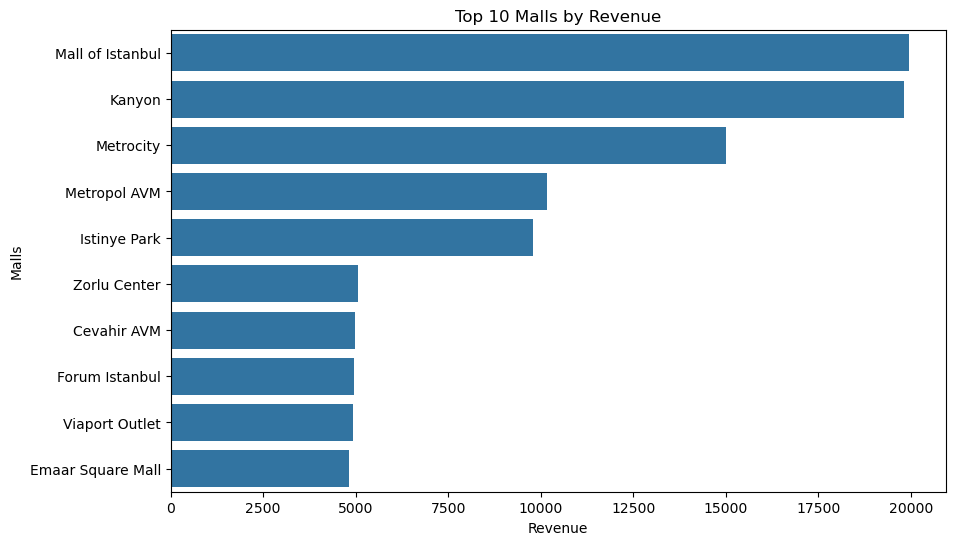

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


country_Malls = df.groupby('shopping_mall')['total_price'].sum().sort_values(ascending=False)[:10]

plt.figure(figsize=(10,6))
sns.barplot(x=country_revenue.values, y=country_revenue.index)
plt.title("Top 10 Malls by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Malls")
plt.show()

In [23]:
df.shape

(99457, 11)

In [25]:
df["shopping_mall"].unique()

array(['Kanyon', 'Forum Istanbul', 'Metrocity', 'Metropol AVM',
       'Istinye Park', 'Mall of Istanbul', 'Emaar Square Mall',
       'Cevahir AVM', 'Viaport Outlet', 'Zorlu Center'], dtype=object)

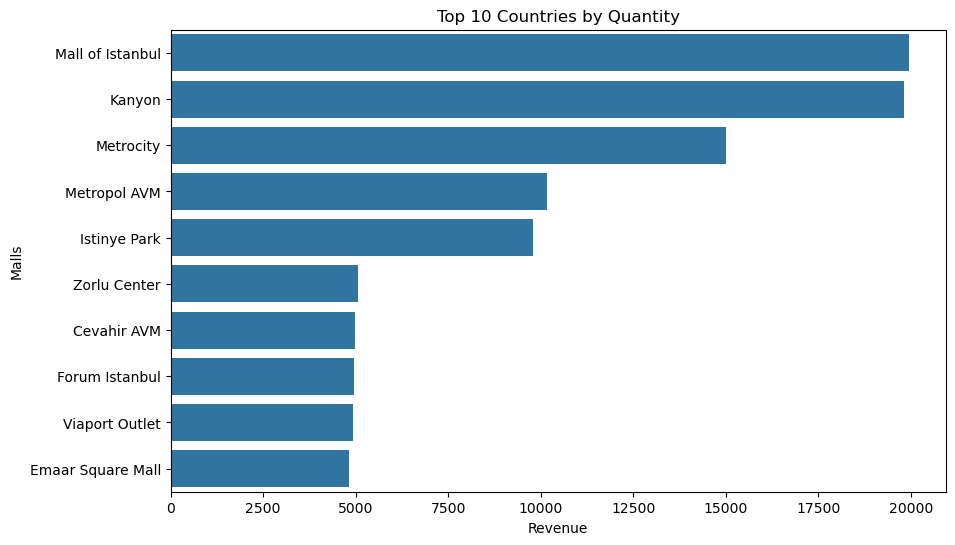

In [27]:
Malls_revenue = df.groupby('shopping_mall')['quantity'].count().sort_values(ascending=False)[:10]

plt.figure(figsize=(10,6))
sns.barplot(x=country_revenue.values, y=country_revenue.index)
plt.title("Top 10 Countries by Quantity")
plt.xlabel("Revenue")
plt.ylabel("Malls")
plt.show()

In [31]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'], format='%d/%m/%Y')

snapshot_date = df['invoice_date'].max() + pd.Timedelta(days=1)
snapshot_date

Timestamp('2023-03-09 00:00:00')

In [33]:
rfm = df.groupby('customer_id').agg({
    'invoice_date': lambda x: (snapshot_date - x.max()).days,
    'invoice_no': 'nunique',
    'total_price': 'sum'
}).reset_index()
rfm

customer_id  invoice_date  invoice_no  total_price
0         C100004           468           1      7502.00
1         C100005             6           1      2400.68
2         C100006            98           1       322.56
3         C100012           571           1       130.75
4         C100019           592           1        35.84
...           ...           ...         ...          ...
99452     C999886             1           1        47.07
99453     C999910           124           1       136.35
99454     C999974           303           1      7502.00
99455     C999976           262           1       322.56
99456     C999995           587           1      1200.32

[99457 rows x 4 columns]

In [35]:
rfm.rename(columns={
    'invoice_date': 'Recency',
    'invoice_no': 'Frequency',
    'total_price': 'Monetary'
}, inplace=True)

rfm = rfm[rfm['Monetary'] > 0]
print(rfm.shape)

rfm.reset_index()
rfm.head()

(99457, 4)


customer_id  Recency  Frequency  Monetary
0     C100004      468          1   7502.00
1     C100005        6          1   2400.68
2     C100006       98          1    322.56
3     C100012      571          1    130.75
4     C100019      592          1     35.84

In [37]:
rfm.columns

Index(['customer_id', 'Recency', 'Frequency', 'Monetary'], dtype='object')

<Axes: xlabel='Recency', ylabel='Count'>

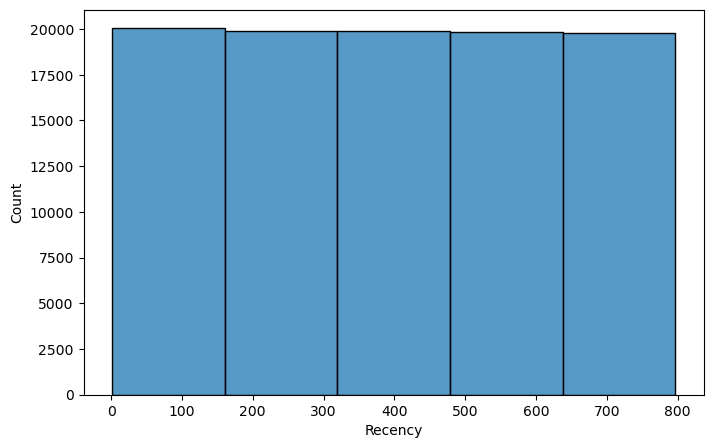

In [39]:
plt.figure(figsize=(8,5))
sns.histplot(rfm['Recency'], bins=5)

In [41]:
rfm['Frequency'].unique()

array([1], dtype=int64)

<Axes: xlabel='Frequency', ylabel='Count'>

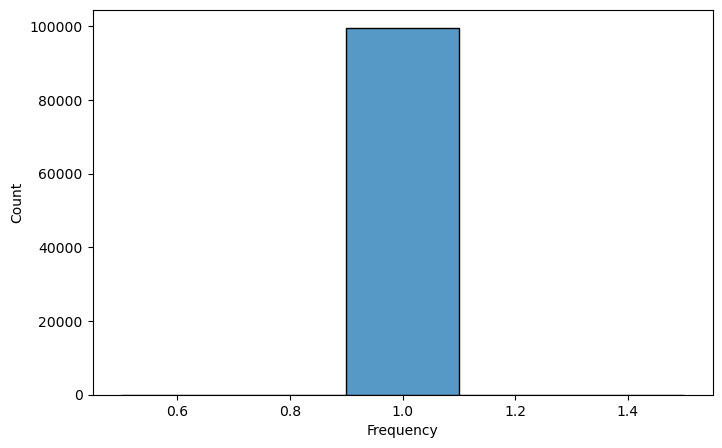

In [43]:
plt.figure(figsize=(8,5))
sns.histplot(rfm['Frequency'], bins=5)

<Axes: xlabel='Monetary', ylabel='Count'>

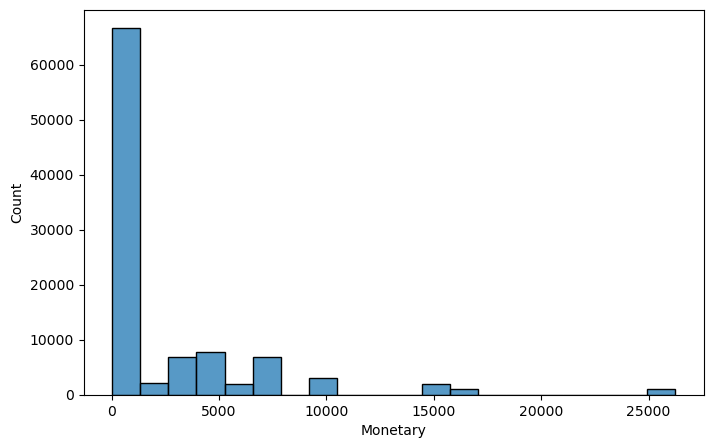

In [45]:
plt.figure(figsize=(8,5))
sns.histplot(rfm['Monetary'], bins=20)

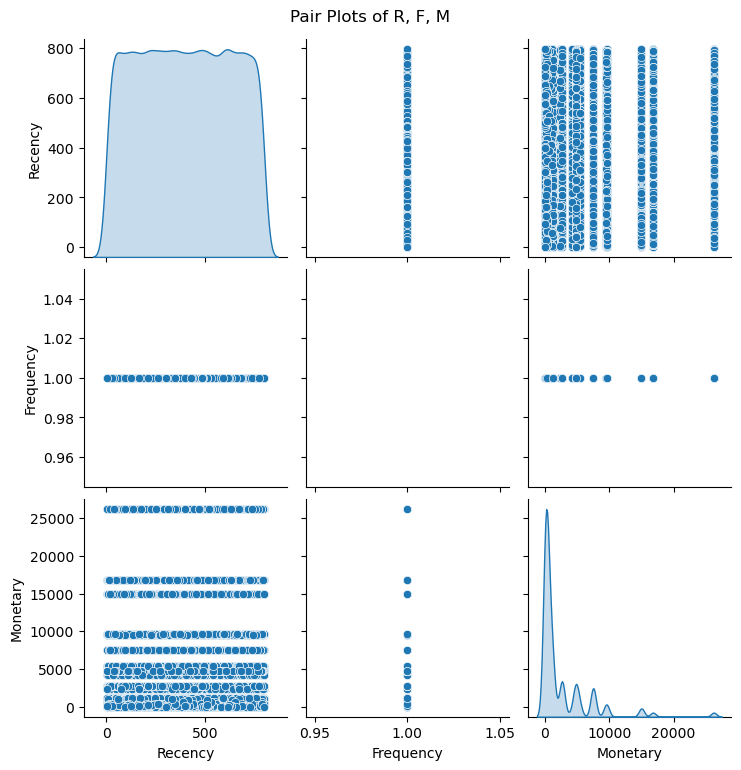

In [47]:
sns.pairplot(rfm, diag_kind='kde')
plt.suptitle("Pair Plots of R, F, M", y=1.02)
plt.show()


In [61]:
rfm.dropna(subset=['Recency', 'Frequency', 'Monetary'], inplace=True)

r_labels = range(5, 0, -1)
f_labels = m_labels = range(1, 6)

rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=r_labels)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=f_labels)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=m_labels)

rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

print(rfm.head())

  customer_id  Recency  Frequency  Monetary  R_Score  F_Score  M_Score
0     C100004      468          1   7502.00        3        1        5
1     C100005        6          1   2400.68        5        1        4
2     C100006       98          1    322.56        5        1        3
3     C100012      571          1    130.75        2        1        2
4     C100019      592          1     35.84        2        1        1


In [65]:
rfm['RFM_Score'] = rfm['R_Score'].map(str) + rfm['F_Score'].map(str) + rfm['M_Score'].map(str)
rfm.head()


customer_id  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0     C100004      468          1   7502.00        3        1        5   
1     C100005        6          1   2400.68        5        1        4   
2     C100006       98          1    322.56        5        1        3   
3     C100012      571          1    130.75        2        1        2   
4     C100019      592          1     35.84        2        1        1   

  RFM_Score  
0       315  
1       514  
2       513  
3       212  
4       211

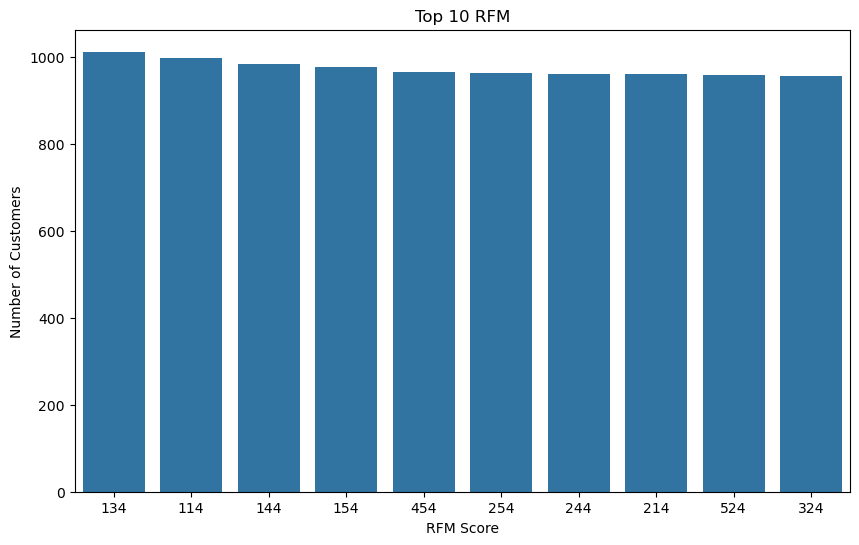

In [69]:
top_scores = rfm['RFM_Score'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_scores.index, y=top_scores.values)
plt.title("Top 10 RFM")
plt.xlabel("RFM Score")
plt.ylabel("Number of Customers")
plt.show()

In [75]:
def segment_customer(df):
    if df['RFM_Score'] == '555':
        return 'Champions'
    elif df['R_Score'] >= 4:
        return 'Loyal'
    elif df['F_Score'] >= 4:
        return 'Frequent'
    elif df['M_Score'] >= 4:
        return 'Good customer'
    elif df['R_Score'] <= 2:
        return 'On Risk'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)
rfm

customer_id  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0         C100004      468          1   7502.00        3        1        5   
1         C100005        6          1   2400.68        5        1        4   
2         C100006       98          1    322.56        5        1        3   
3         C100012      571          1    130.75        2        1        2   
4         C100019      592          1     35.84        2        1        1   
...           ...      ...        ...       ...      ...      ...      ...   
99452     C999886        1          1     47.07        5        5        1   
99453     C999910      124          1    136.35        5        5        2   
99454     C999974      303          1   7502.00        4        5        5   
99455     C999976      262          1    322.56        4        5        3   
99456     C999995      587          1   1200.32        2        5        4   

      RFM_Score        Segment  
0           315  Good customer  
1           514          Loyal  
2           513          Loyal  
3           212        On Risk  
4           211        On Risk  
...         ...            ...  
99452       551          Loyal  
99453       552          Loyal  
99454       455          Loyal  
99455       453          Loyal  
99456       254       Frequent  

[99457 rows x 9 columns]

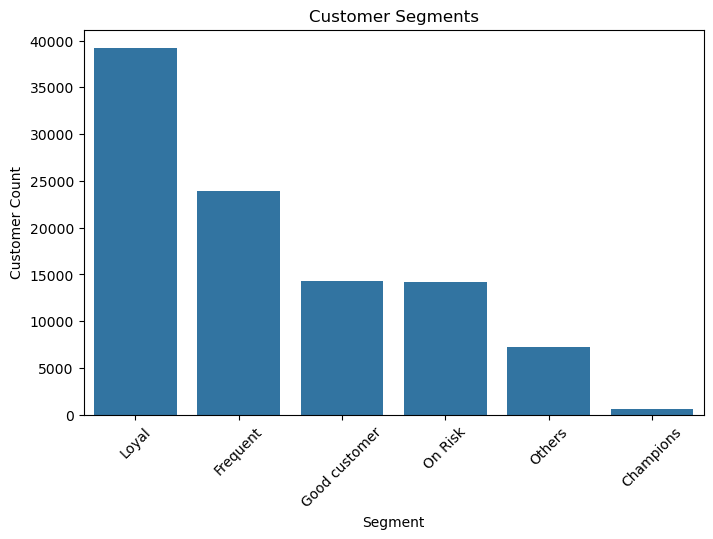

In [77]:
plt.figure(figsize=(8, 5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index)
plt.title("Customer Segments")
plt.xlabel("Segment")
plt.ylabel("Customer Count")
plt.xticks(rotation=45)
plt.show()


In [79]:
rfm_clustering = rfm[['Recency', 'Frequency', 'Monetary']].copy()
rfm_clustering


Recency  Frequency  Monetary
0          468          1   7502.00
1            6          1   2400.68
2           98          1    322.56
3          571          1    130.75
4          592          1     35.84
...        ...        ...       ...
99452        1          1     47.07
99453      124          1    136.35
99454      303          1   7502.00
99455      262          1    322.56
99456      587          1   1200.32

[99457 rows x 3 columns]

In [81]:
print(rfm_clustering.isnull().sum())

Recency      0
Frequency    0
Monetary     0
dtype: int64


In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clustering)


In [85]:
rfm_scaled

array([[ 0.30502419,  0.        ,  1.17780089],
       [-1.70480575,  0.        , -0.03034   ],
       [-1.30457987,  0.        , -0.52249923],
       ...,
       [-0.41277222,  0.        ,  1.17780089],
       [-0.59113375,  0.        , -0.52249923],
       [ 0.82270766,  0.        , -0.31462015]])

In [87]:
from sklearn.cluster import KMeans
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


C:\Users\RITIKA\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\RITIKA\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\RITIKA\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RITIKA\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\RITIKA\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.Crea

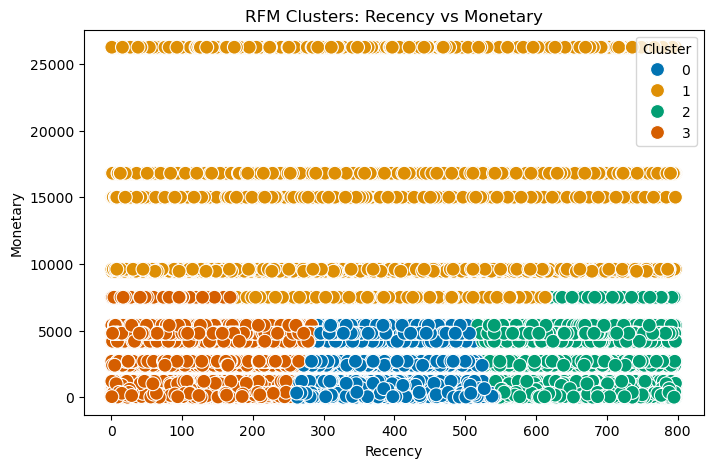

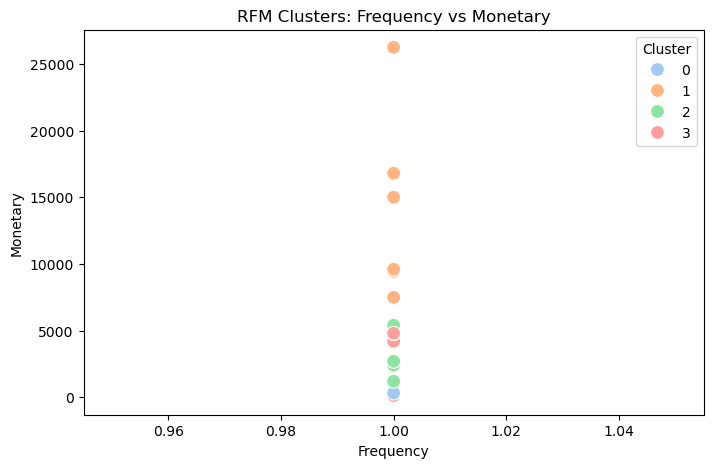

In [99]:
palette1 = 'colorblind'  
palette2 = 'pastel'      

plt.figure(figsize=(8, 5))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette=palette1, s=100)
plt.title('RFM Clusters: Recency vs Monetary')
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette=palette2, s=100)
plt.title('RFM Clusters: Frequency vs Monetary')
plt.show()

In [101]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

cluster_summary.columns = ['Recency_Mean', 'Frequency_Mean', 'Monetary_Mean', 'Customer_Count']
cluster_summary.reset_index()

Cluster  Recency_Mean  Frequency_Mean  Monetary_Mean  Customer_Count
0        0         399.9             1.0         1043.5           29140
1        1         394.6             1.0        12007.1           10963
2        2         668.3             1.0         1532.3           29487
3        3         130.1             1.0         1482.6           29867

In [103]:
rfm

customer_id  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0         C100004      468          1   7502.00        3        1        5   
1         C100005        6          1   2400.68        5        1        4   
2         C100006       98          1    322.56        5        1        3   
3         C100012      571          1    130.75        2        1        2   
4         C100019      592          1     35.84        2        1        1   
...           ...      ...        ...       ...      ...      ...      ...   
99452     C999886        1          1     47.07        5        5        1   
99453     C999910      124          1    136.35        5        5        2   
99454     C999974      303          1   7502.00        4        5        5   
99455     C999976      262          1    322.56        4        5        3   
99456     C999995      587          1   1200.32        2        5        4   

      RFM_Score        Segment  Cluster  
0           315  Good customer        1  
1           514          Loyal        3  
2           513          Loyal        3  
3           212        On Risk        2  
4           211        On Risk        2  
...         ...            ...      ...  
99452       551          Loyal        3  
99453       552          Loyal        3  
99454       455          Loyal        1  
99455       453          Loyal        0  
99456       254       Frequent        2  

[99457 rows x 10 columns]

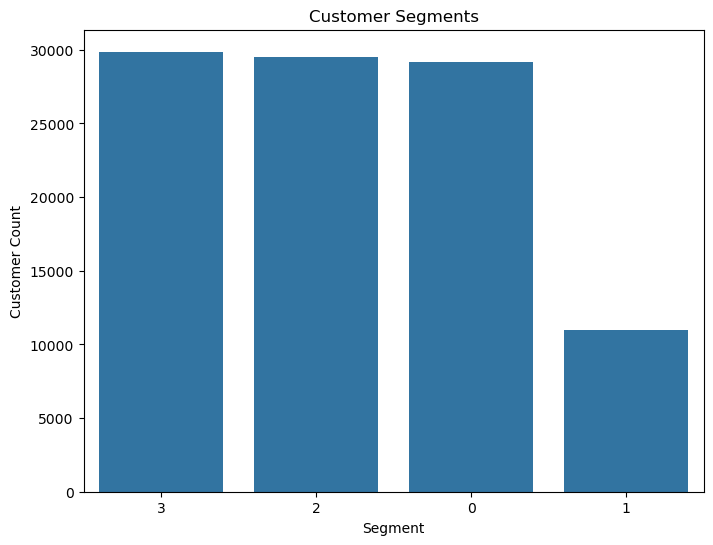

In [109]:
plt.figure(figsize=(8,6))
sns.countplot(data=rfm, x='Cluster', order=rfm['Cluster'].value_counts().index)
plt.title("Customer Segments")
plt.xlabel("Segment")
plt.ylabel("Customer Count")
plt.show()
